In [1]:
import numpy as np
import json
import pandas as pd
import matplotlib.pyplot as plt
import GPy
from sklearn.linear_model import LinearRegression
import collections

In [2]:
num_account = 50000
losses_account_array_single = []
index_array = []
for i in range(num_account):
    f = open("../smallAccount/account_" + str(i) + ".json", "r")
    temp = json.load(f)
    if len(temp['hazard']['perils'][0]["locations"]) == 1:
        losses_account_array_single.append(temp)
        index_array.append(i)
np.random.seed(0)

In [3]:
x_data = []
y_data = []
periods_data = []
year_bulids_array = []
num_floor_array = []
bsum_array = []
for index, losses_account in enumerate(losses_account_array_single):
    x = losses_account["exposure"]["locations"][0]["x"]
    y = losses_account["exposure"]["locations"][0]["y"]
    year = losses_account["exposure"]["locations"][0]["yearBuilt"]
    num_floor = losses_account["exposure"]["locations"][0]["numberFloors"]
    bsum = losses_account["exposure"]["locations"][0]['bsum']
    periods_data_temp = []
    for i in range(len(losses_account['hazard']['perils'][0]["locations"][0]['attributes_rp'][0]["return_periods"])):
        periods_data_temp.append(losses_account['hazard']['perils'][0]["locations"][0]['attributes_rp'][0]["return_periods"][i]['value'])
    periods_data.append(periods_data_temp)
    x_data.append(x)
    y_data.append(y)
    year_bulids_array.append(year)
    num_floor_array.append(num_floor)
    bsum_array.append(bsum)
periods_data = np.array(periods_data, dtype=np.float32)
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)
year_bulids_array = np.array(year_bulids_array, dtype=np.float32)
num_floor_array = np.array(num_floor_array, dtype=np.float32)
bsum_array = np.array(bsum_array, dtype=np.float32)

In [4]:
AAL_GU_array = []
EP_GU_array = []
for index in index_array:
    f = open("../results/losses_Account_" + str(index) + ".csv", "r")
    l = f.readlines()
    temp = l[1].split(",")
    AAL_GU_array.append(float(temp[1]))
    EP_GU_array.append(np.array([temp[i+3] for i in range(10)], dtype=np.float32))
AAL_GU_array = np.array(AAL_GU_array, dtype=np.float32)
EP_GU_array = np.array(EP_GU_array, dtype=np.float32)

In [5]:
random_index = np.arange(len(index_array))
np.random.shuffle(random_index)

In [6]:
random_x_data = x_data[random_index]
random_y_data = y_data[random_index]
random_periods_data = periods_data[random_index]
random_AAL_GU_array = AAL_GU_array[random_index]
random_EP_GU_array = EP_GU_array[random_index]
random_bsum_array = bsum_array[random_index]

In [7]:
#1次元のガウス過程回帰
num_train = 1000
kernel = GPy.kern.RBF(input_dim=9, variance=1., lengthscale=1.)
x = random_periods_data[:, :]
y = np.log(random_AAL_GU_array/random_bsum_array)
x_train = x[:num_train]
y_train = y[:num_train]
m = GPy.models.GPRegression(x_train, y_train[:, np.newaxis], kernel)
m.optimize(messages=True)

In [8]:
y_pred = m.predict(x[num_train:])[0]
y_pred = np.exp(y_pred)
y_test = random_AAL_GU_array[num_train:]/random_bsum_array[num_train:]
np.linalg.norm(y_pred.T-y_test)/np.linalg.norm(y_test)*100

0.04105041853970336

In [9]:
not_index_array = []
for i in range(num_account):
    if i not in index_array:
        not_index_array.append(i)

In [10]:
#全てのアカウントからランダムに3000個のアカウントを選ぶ.
num_select = 5000
test_index = np.arange(num_account-len(losses_account_array_single))
np.random.shuffle(not_index_array)
test_index = not_index_array[:num_select]

In [11]:
losses_account_array_multi = []
for i in range(num_select):
    f = open("../smallAccount/account_" + str(test_index[i]) + ".json", "r")
    temp = json.load(f)
    if len(temp['hazard']['perils'][0]["locations"]) != 1:
        losses_account_array_multi.append(temp)

In [12]:
x_data = []
y_data = []
periods_data = []
year_bulids_array = []
num_floor_array = []
bsum_array = []
bsum_per_account_array = []
account_len_array = []
account_number_array = []
for i, index in enumerate(test_index):
    losses_account = losses_account_array_multi[i]
    bsum_per_account = losses_account["exposure"]["bsum"]
    account_len_array.append(len(losses_account["exposure"]["locations"]))
    bsum_per_account_array.append(bsum_per_account)
    for locate_index in range(len(losses_account["exposure"]["locations"])):
        x = losses_account["exposure"]["locations"][locate_index]["x"]
        y = losses_account["exposure"]["locations"][locate_index]["y"]
        year = losses_account["exposure"]["locations"][locate_index]["yearBuilt"]
        num_floor = losses_account["exposure"]["locations"][locate_index]["numberFloors"]
        bsum = losses_account["exposure"]["locations"][locate_index]['bsum']
        periods_data_temp = []
        for i in range(len(losses_account['hazard']['perils'][0]["locations"][locate_index]['attributes_rp'][0]["return_periods"])):
            periods_data_temp.append(losses_account['hazard']['perils'][0]["locations"][locate_index]['attributes_rp'][0]["return_periods"][i]['value'])
        periods_data.append(periods_data_temp)
        x_data.append(x)
        y_data.append(y)
        year_bulids_array.append(year)
        num_floor_array.append(num_floor)
        bsum_array.append(bsum)
        account_number_array.append(index)
periods_data = np.array(periods_data, dtype=np.float32)
x_data = np.array(x_data, dtype=np.float32)
y_data = np.array(y_data, dtype=np.float32)
year_bulids_array = np.array(year_bulids_array, dtype=np.float32)
num_floor_array = np.array(num_floor_array, dtype=np.float32)
bsum_array = np.array(bsum_array, dtype=np.float32)
bsum_per_account_array = np.array(bsum_per_account_array, dtype=np.float32)
account_len_array = np.array(account_len_array, dtype=np.int0)

In [13]:
AAL_GU_array

array([3619.7056 , 5241.6387 , 1117.932  , ...,  752.80975,  342.29456,
        659.1931 ], dtype=float32)

In [14]:
AAL_GU_array = []
EP_GU_array = []
AAL_GR_array = []
for index in test_index:
    f = open("../results/losses_Locations_" + str(index) + ".csv", "r")
    l = f.readlines()
    temp_array = []
    temp_array_2 = []
    for i in range(len(l)-1):
        temp = l[1+i].split(",")
        AAL_GU_array.append(float(temp[2]))
        AAL_GR_array.append(float(temp[3]))
        temp_array.append(float(temp[2]))
        temp_array_2.append(float(temp[3]))
    f = open("../results/losses_Account_" + str(index) + ".csv", "r")
    l = f.readlines()
    temp = l[1].split(",")
    temp_array = np.array(temp_array, dtype=np.float32)
    temp_2 = l[1].split(",")
    temp_array_2 = np.array(temp_array_2, dtype=np.float32)
    if np.abs(float(temp[1]) - np.sum(temp_array)) > 0.2:
        print(index)
    if np.abs(float(temp_2[2]) - np.sum(temp_array_2)) > 0.1:
        print(index)
        # EP_GU_array.append(np.array([temp[i+3] for i in range(10)], dtype=np.float32))
AAL_GU_array = np.array(AAL_GU_array, dtype=np.float32)
account_number_array = np.array(account_number_array, dtype=np.int0)
# EP_GU_array = np.array(EP_GU_array, dtype=np.float32)

In [27]:
y_pred, y_var = m.predict(periods_data)
y_pred = np.exp(y_pred)
y_pred_sum = np.zeros(len(test_index))
y_true_sum = np.zeros(len(test_index))
for i, index_i in enumerate(test_index):
    index = np.where(account_number_array == index_i)
    y_pred_sum[i] = np.sum(y_pred[index])
    y_true_sum[i] = np.sum(AAL_GU_array[index]/bsum_array[index])

In [28]:
np.linalg.norm(y_pred_sum-y_true_sum)/np.linalg.norm(y_true_sum)*100   

0.43197347054178203

In [30]:
np.linalg.norm(y_pred.T-AAL_GU_array/bsum_array)/np.linalg.norm(AAL_GU_array/bsum_array)*100

11.886137170971782

Text(0, 0.5, 'latitude')

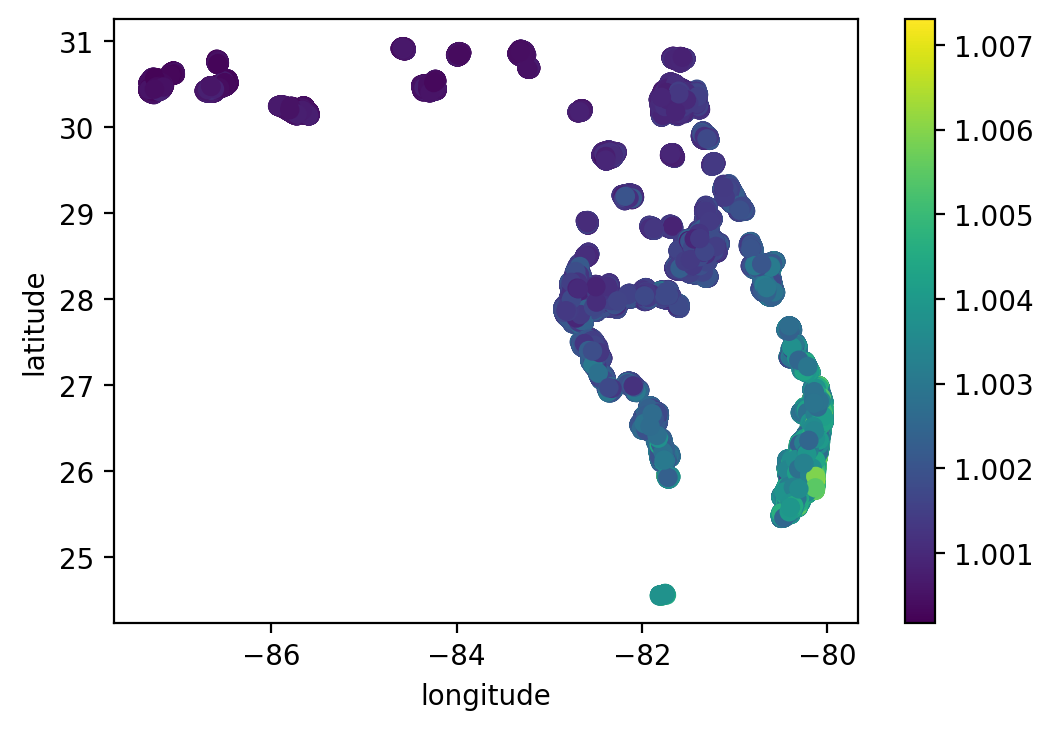

In [180]:
plt.figure(dpi = 200)
plt.scatter(x_data, y_data, c = np.exp(y_pred))
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")

Text(0, 0.5, 'latitude')

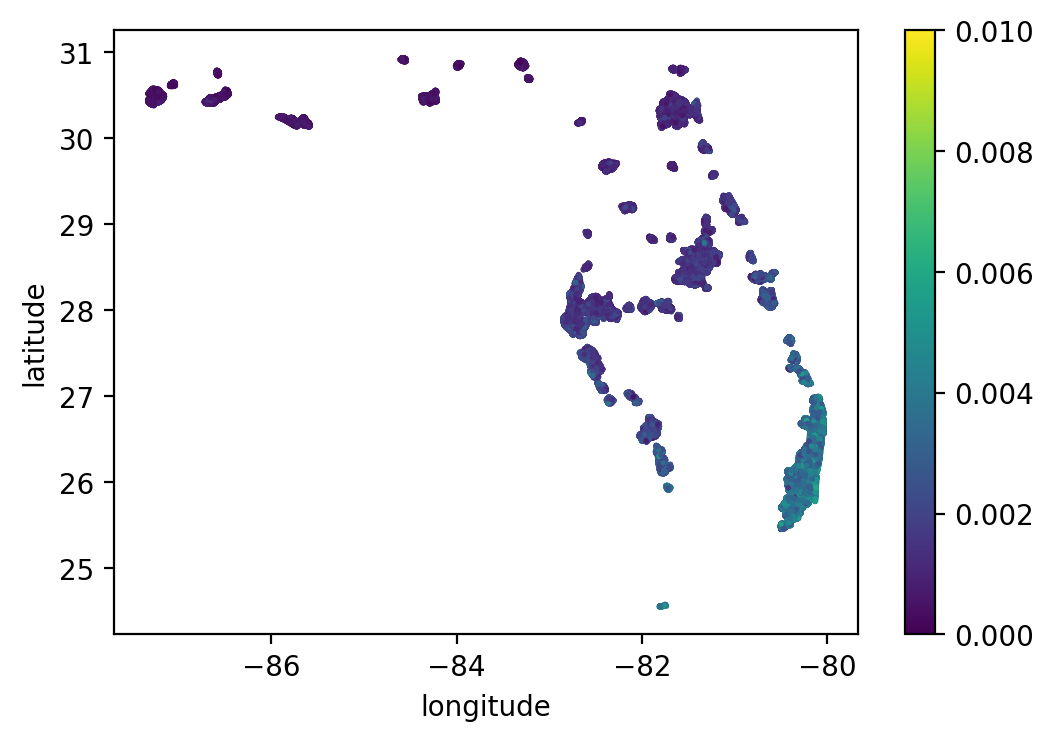

In [186]:
plt.figure(dpi = 200)
plt.scatter(x_data, y_data, c = AAL_GU_array/bsum_array,s=1,vmin=0,vmax=0.01)
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")

Text(0, 0.5, 'latitude')

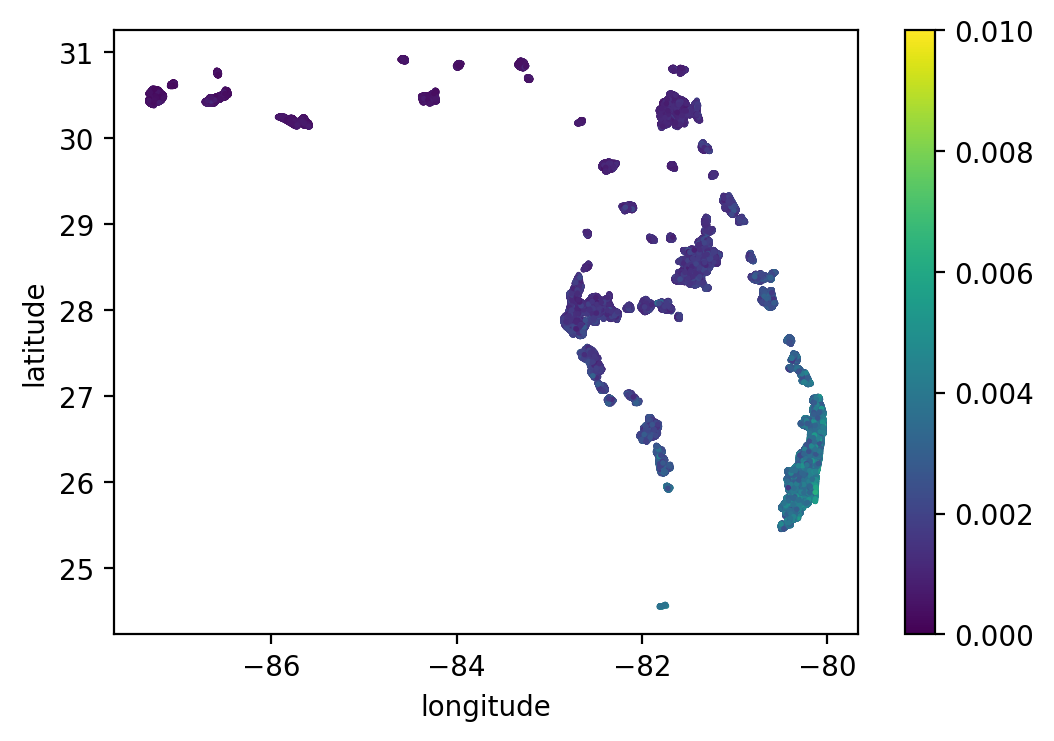

In [189]:
plt.figure(dpi = 200)
plt.scatter(x_data, y_data, c = y_pred,s=1,vmin=0,vmax=0.01)
plt.colorbar()
plt.xlabel("longitude")
plt.ylabel("latitude")

Text(0, 0.5, 'Predicted per location')

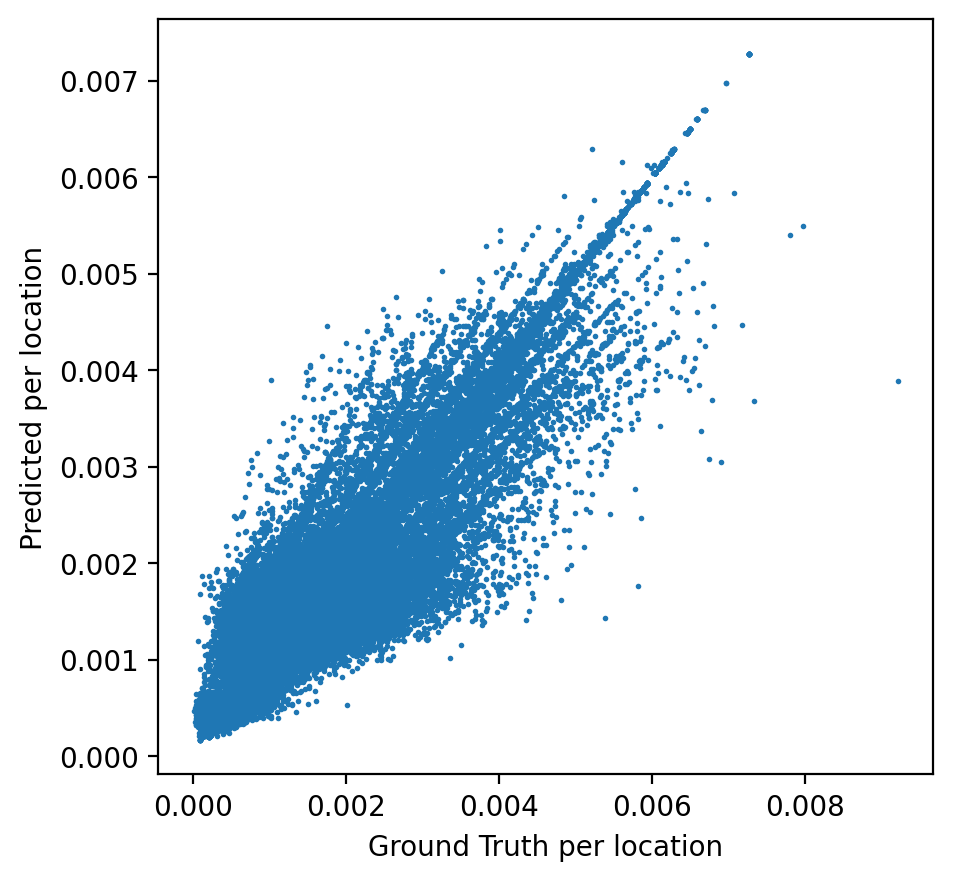

In [198]:
plt.figure(dpi = 200, figsize=(5,5))
plt.scatter(AAL_GU_array/bsum_array,y_pred, s=1)
plt.xlabel("Ground Truth per location")
plt.ylabel("Predicted per location")

Text(0, 0.5, 'Predicted per account')

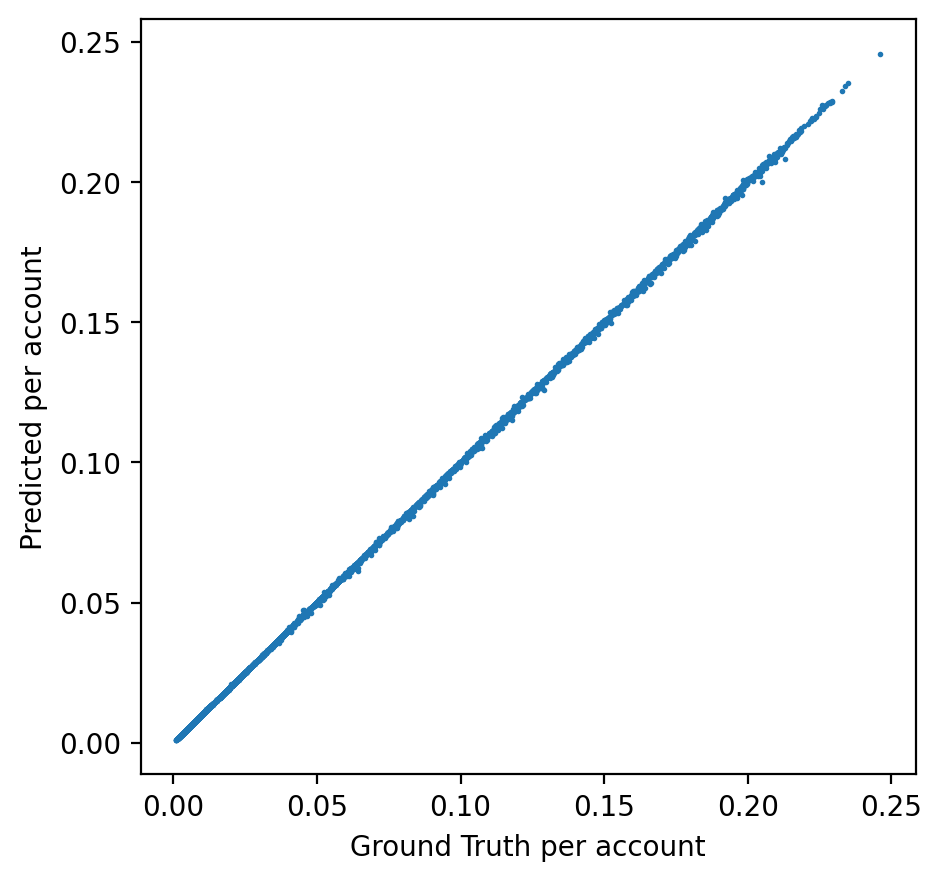

In [200]:
plt.figure(dpi = 200, figsize=(5,5))
plt.scatter(y_true_sum,y_pred_sum, s=1)
plt.xlabel("Ground Truth per account")
plt.ylabel("Predicted per account")

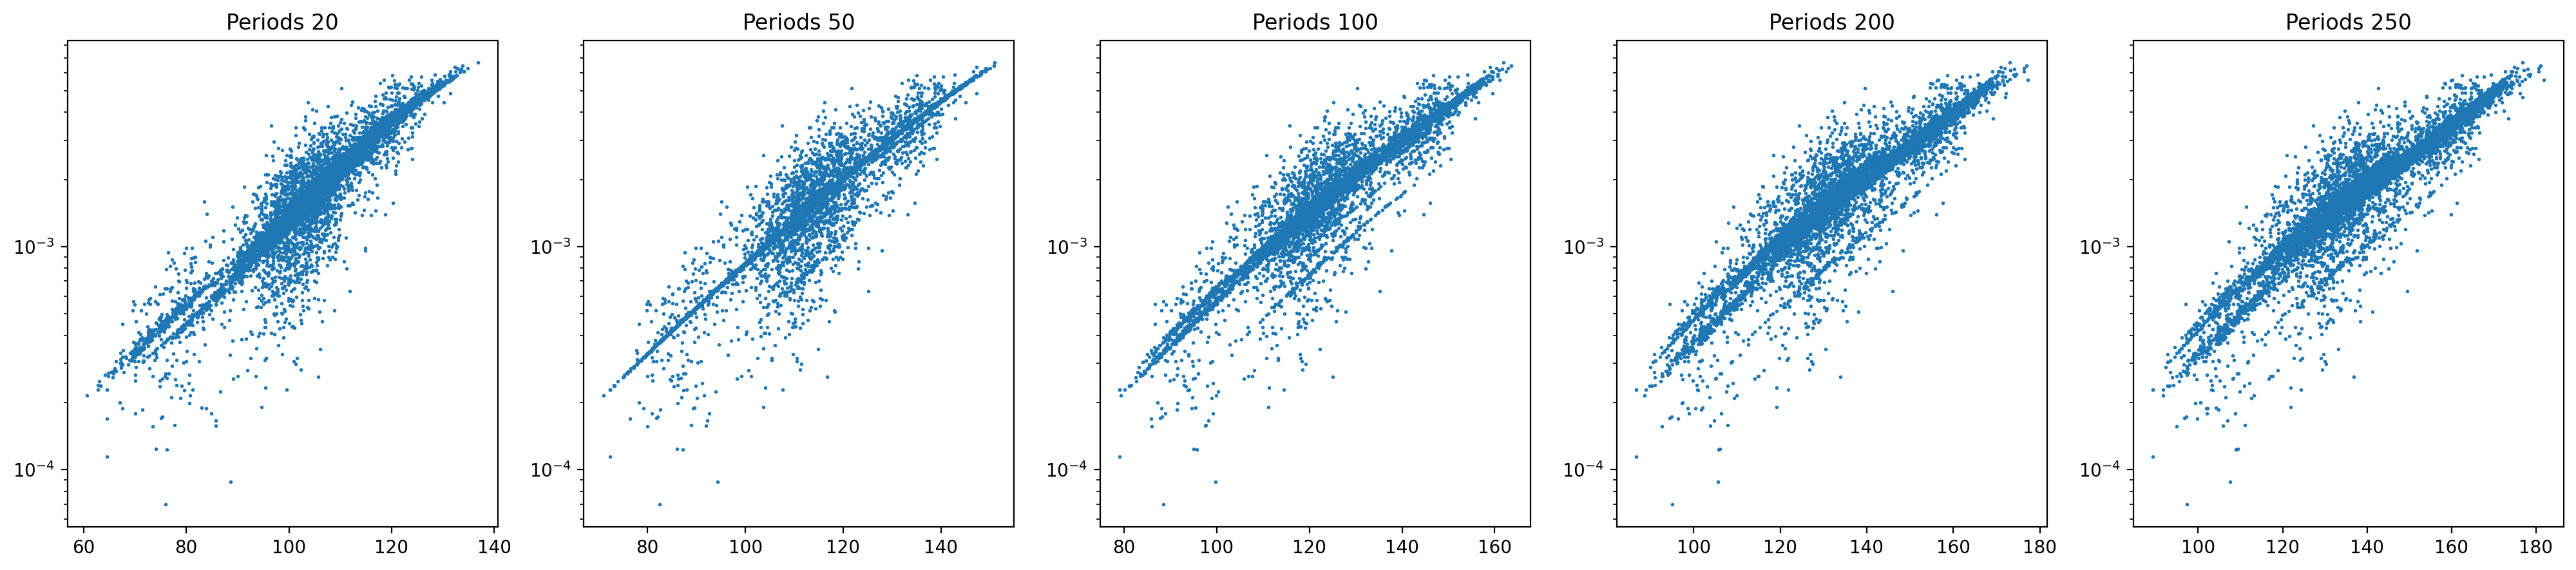

In [38]:
fig , axs= plt.subplots(1, 5, figsize=(25, 5),dpi = 200)
title = ["20","50","100","200","250","475","500","1000","2500"]
for i in range(5):
    axs[i].scatter(periods_data[:10000, i], AAL_GU_array[:10000]/bsum_array[:10000],s = 1)
    axs[i].set_title("Periods " + title[i])
    axs[i].set_yscale('log')
#x軸のラベル, y軸のラベルを全体に表示
# fig.text(0.5, 0.04, 'Risk of Hurricane', ha='center', va='center', fontsize=20)
# fig.text(0.06, 0.5, 'Ground up loss/building value', ha='center', va='center', rotation='vertical', fontsize=20)